In [33]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset

In [2]:

class Person():
	""" Person (parent?) class -- will define how the person takes in a points signal and puts out an energy signal 
	baseline_energy = a list or dataframe of values. This is data from SinBerBEST 
	points_multiplier = an int which describes how sensitive each person is to points 

	"""

	def __init__(self, baseline_energy_df, points_multiplier = 1):
		self.baseline_energy_df = baseline_energy_df
		self.baseline_energy = np.array(self.baseline_energy_df["net_energy_use"])
		self.points_multiplier = points_multiplier
		
		baseline_min = self.baseline_energy.min()
		baseline_max = self.baseline_energy.max()
		baseline_range = baseline_max - baseline_min
		
		self.min_demand = np.maximum(0, baseline_min + baseline_range * .05)
		self.max_demand = np.maximum(0, baseline_min + baseline_range * .95)


	def energy_output_simple_linear(self, points):
		"""Determines the energy output of the person, based on the formula:
		
		y[n] = -sum_{rolling window of 5} points + baseline_energy + noise

		inputs: points - list or dataframe of points values. Assumes that the 
		list will be in the same time increment that energy_output will be. 

		For now, that's in 1 hour increments

		"""
		points_df = pd.DataFrame(points)
		
		points_effect = (
			points_df
				.rolling(
						window = 5,
						min_periods = 1)
				.mean()
			)

		time = points_effect.shape[0]
		energy_output= []

		for t in range(time):
			temp_energy = self.baseline_energy[t] - points_effect.iloc[t]*self.points_multiplier + \
				np.random.normal(1)
			energy_output.append(temp_energy)
			
		return pd.DataFrame(energy_output)

	def pure_linear_signal(self, points, baseline_day=0):
		"""
		A linear person. The more points you give them, the less energy they will use
		(within some bounds) for each hour. No rolling effects or anything. The simplest
		signal. 
		"""

		# hack here to always grab the first day from the baseline_energy
		output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]

		points_effect = np.array(points * self.points_multiplier)
		output = output - points_effect

		# impose bounds/constraints
		output = np.maximum(output, self.min_demand)
		output = np.minimum(output, self.max_demand)
		return output



	def get_min_demand(self):
		return self.min_demand
		# return np.quantile(self.baseline_energy, .05)

	def get_max_demand(self):
		return self.max_demand
		# return np.quantile(self.baseline_energy, .95)

class FixedDemandPerson(Person):

	def __init__(self, baseline_energy_df, points_multiplier = 1):
		super().__init__(baseline_energy_df, points_multiplier)


	def demand_from_points(self, points, baseline_day=0):
		# hack here to always grab the first day from the baseline_energy
		output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]
		total_demand = np.sum(output)


		points_effect = np.array(points * self.points_multiplier)
		output = output - points_effect

		# scale to keep total_demand (almost) constant
		# almost bc imposing bounds afterwards
		output = output * (total_demand/np.sum(output))

		# impose bounds/constraints
		output = np.maximum(output, self.min_demand)
		output = np.minimum(output, self.max_demand)

		return output

	def adverserial_linear(self, points, baseline_day=0):
		# hack here to always grab the first day from the baseline_energy
		output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]
		total_demand = np.sum(output)


		points_effect = np.array(points * self.points_multiplier)
		output = output + points_effect

		# scale to keep total_demand (almost) constant
		# almost bc imposing bounds afterwards
		output = output * (total_demand/np.sum(output))

		# impose bounds/constraints
		output = np.maximum(output, self.min_demand)
		output = np.minimum(output, self.max_demand)

		return output

In [3]:
class CurtailAndShiftPerson(Person):
	def __init__(self, baseline_energy_df, points_multiplier = 1, shiftable_load_frac = .7, 
			curtailable_load_frac = .4, shiftByHours = 3, maxCurtailHours=5, response = None, **kwargs):
		super().__init__(baseline_energy_df, points_multiplier)
		self.shiftableLoadFraction = shiftable_load_frac
		self.shiftByHours = shiftByHours
		self.curtailableLoadFraction = curtailable_load_frac
		self.maxCurtailHours = maxCurtailHours #Person willing to curtail for no more than these hours

	def shiftedLoad(self, points, baseline_day=0, day_of_week=None):
		output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]
		points = np.array(points) * self.points_multiplier
		shiftableLoad = self.shiftableLoadFraction*output
		shiftByHours = self.shiftByHours
		
		# 10 hour day. Rearrange the sum of shiftableLoad into these hours by treating points as the 'price' at that hour
		# Load can be shifted by a max of shiftByHours (default = 3 hours)
		# For each hour, calculate the optimal hour to shift load to within +- 3 hours
		shiftedLoad = np.zeros(10)
		for hour in range(10):
			candidatePrices = points[max(hour-shiftByHours,0): min(hour+shiftByHours,9)+1]
			shiftToHour = max(hour-shiftByHours,0) + np.argmin(candidatePrices)
			shiftedLoad[shiftToHour] += shiftableLoad[hour]		
		return shiftedLoad

	def curtailedLoad(self, points, baseline_day=0, day_of_week=None):
		output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]
		points = np.array(points) * self.points_multiplier
		curtailableLoad = self.curtailableLoadFraction*output
		maxPriceHours = np.argsort(points)[0:self.maxCurtailHours]
		for hour in maxPriceHours:
			curtailableLoad[hour] = 0
		return curtailableLoad

	def get_response(self, points, day_of_week=None):
		baseline_day = 0
		output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]
		energy_resp = output*(1 - self.curtailableLoadFraction - self.shiftableLoadFraction) + self.curtailedLoad(points) + self.shiftedLoad(points)
		
			
		self.min_demand = np.maximum(0, min(energy_resp))
		self.max_demand = np.maximum(0, max(energy_resp))

		return energy_resp





In [4]:
a = {"net_energy_use":[15.09,  35.6, 123.5,  148.7,  158.49, 149.13, 159.32, 157.62, 158.8,  156.49]}

In [5]:
bob = CurtailAndShiftPerson(baseline_energy_df=a)

In [6]:
def get_datasets(train_size, val_size):
    output_data = []
    # square_waves = np.array([[0,0,0,0,0,0,0,0,1,0],
    #                         [0,0,0,0,0,0,0,0,1,0],
    #                         [1,0,0,0,0,0,0,0,0,0],
    #                         [1,0,0,0,0,0,0,0,0,0],
    #                         [0,1,0,0,0,0,0,0,0,0],
    #                         [0,1,0,0,0,0,0,0,0,0],
    #                         [0,0,1,0,0,0,0,0,0,1],
    #                         [0,0,1,0,0,0,0,0,0,1],
    #                         [0,0,0,1,0,0,0,0,0,0],
    #                         [0,0,0,1,0,0,0,0,0,0]])
    square_waves = np.random.uniform(size=[train_size, 10])
    square_waves /= np.sum(square_waves, axis=-1, keepdims=True)
    validation_waves = np.random.uniform(size=[val_size, 10])
    validation_waves = validation_waves  / np.sum(validation_waves, axis=-1, keepdims=True)
    validation_data = []

    for day in range(square_waves.shape[0]):
        output_data.append(bob.get_response(square_waves[day]))
    for day in range(validation_waves.shape[0]):
        validation_data.append(bob.get_response(validation_waves[day]))
        
    output_data=np.array(output_data)
    validation_data = np.array(validation_data)
    return square_waves, validation_waves, output_data, validation_data

In [7]:
train_size = 1000
val_size = 256
square_waves, validation_waves, output_data, validation_data = get_datasets(train_size, val_size)

In [8]:
import pandas as pd
pd.DataFrame(output_data).describe()

,0,1,2,3,4,5,6,7,8,9
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,39.698277,49.741772,89.547670,97.491385,111.112377,133.848905,151.075596,127.112730,111.148506,99.537134
std,79.159013,102.397815,143.345959,164.510602,187.619304,220.172471,241.365738,203.756808,172.881399,144.091323
min,-1.509000,-3.560000,-12.350000,-14.870000,-15.849000,-14.913000,-15.932000,-15.762000,-15.880000,-15.649000
25%,-1.509000,7.003000,23.133000,-4.307000,47.547000,44.739000,47.796000,47.286000,47.640000,46.947000
50%,4.527000,10.680000,37.050000,44.610000,47.547000,44.739000,47.796000,47.286000,47.640000,46.947000
75%,9.054000,10.680000,37.050000,44.610000,47.547000,96.247000,93.611000,93.781000,88.511000,93.894000
max,224.514000,333.406000,429.007000,538.011000,636.803000,723.979000,746.053000,642.133000,531.072000,426.912000


In [9]:
square_waves[:, 1]
validation_waves[1]

array([0.11026045, 0.09541252, 0.20807487, 0.05446435, 0.01908912,
       0.06173294, 0.10242151, 0.12506258, 0.0214095 , 0.20207216])

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.0001, 1))
#square_waves = scaler.fit_transform(square_waves)
#val_waves = scaler.transform(validation_waves)
train_data_normalized = output_data # scaler.fit_transform(output_data.reshape(-1, 1))
val_data_normalized = validation_data #scaler.transform(validation_data.reshape(-1, 1))

In [11]:
pd.DataFrame(square_waves).describe()

,0,1,2,3,4,5,6,7,8,9
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.099974,0.100986,0.098806,0.099439,0.102508,0.100685,0.098361,0.098855,0.100363,0.100024
std,0.057895,0.057125,0.059602,0.057822,0.056223,0.057850,0.057590,0.057288,0.056442,0.056377
min,0.000009,0.000218,0.000088,0.000025,0.000289,0.000013,0.000117,0.000081,0.000203,0.000246
25%,0.053000,0.055134,0.047596,0.050171,0.057769,0.054698,0.051472,0.053000,0.056502,0.055845
50%,0.099170,0.102995,0.099848,0.099550,0.104730,0.100738,0.098074,0.094865,0.099334,0.098844
75%,0.143233,0.142501,0.144533,0.142923,0.145189,0.144227,0.142630,0.143364,0.142351,0.139596
max,0.275052,0.285007,0.266641,0.271807,0.268244,0.314187,0.346329,0.313522,0.353342,0.287925


In [12]:
output_data_normalized = train_data_normalized.reshape([-1,10])
val_data_normalized = val_data_normalized.reshape([-1, 10])

In [13]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, n_layers):
        super(Net, self).__init__()
        self.first_layer = nn.Linear(n_feature, n_hidden)
        self.hiddens = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(n_layers)])
        #self.hidden = torch.nn.Linear(n_feature, n_hidden)
        #self.hidden2 = torch.nn.Linear(n_hidden, n_hidden)
        #self.hidden3 = torch.nn.Linear(n_hidden, n_hidden)  
        self.predict_layer = torch.nn.Linear(n_hidden, n_output)  

    def forward(self, x):
        x = F.relu(self.first_layer(x))
        for hidden in self.hiddens:
            x = hidden(x)
        x = self.predict_layer(x)
        #x = F.relu(self.hidden(x))      
        #x = F.relu(self.hidden2(x))
        #x = F.relu(self.hidden3(x))
        #x = self.predict_layer(x)        
        x = x**2 # ensures costs will all be positive     
        return x, None

class Ensemble(pl.LightningModule):
    def __init__(self, n_feature, n_hidden, n_output, n_layers, n_networks) -> None:
        super(Ensemble, self).__init__()
        self.n_output = n_output
        self.n_networks = n_networks
        self.networks = nn.ModuleList([Net(n_feature, n_hidden, n_output, n_layers) for _ in range(n_networks)])
    
    def forward(self, x):
        outputs = torch.zeros([self.n_networks, len(x), self.n_output])
        for i, network in enumerate(self.networks):
            output, _ = network(x)
            outputs[i] = output
        return outputs.mean(dim=0), outputs.std(dim=0) / np.sqrt(self.n_networks)

In [ ]:
class BaseData(Dataset):
    def __init__(self, num_samples) -> None:
        super().__init__()
        self.num_samples = num_samples
        self.waves, _, self.output, _ = get_datasets(num_samples, 0)

    def __getitem__(self, idx):
        return self.waves[idx], self.output[idx]    

class LitData(pl.LightningDataModule):
    def __init__(self, num_train, num_val, batch_size) -> None:
        super().__init__()
        self.num_train = num_train
        self.num_val = num_val
        self.batch_size = batch_size
    
    def setup(self, stage = None):
        self.train_dataset = BaseData(self.num_train)
        self.val_dataset = BaseData(self.num_val)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, self.batch_size)


In [14]:
#net = Net(n_feature=10, n_hidden=32, n_output=10)     # define the network


In [15]:
# from sklearn.linear_model import ElasticNet
# l1_ratios = [0, 0.1, 0.5, 0.7, 0.95, 0.99, 1]
# alphas = [10**i for i in range(-4, 2, 1)]
# min_loss = None
# best_l1_ratio=None
# best_alpha=None
# for l1_ratio in l1_ratios:
#     for alpha in alphas:
#         elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
#         elastic_net.fit(square_waves.reshape(-1, 1), output_data_normalized.reshape(-1, 1))
#         val_out = elastic_net.predict(validation_waves.reshape(-1, 1))
#         val_loss = loss_func(torch.tensor(val_data_normalized.reshape(-1, 1)), torch.tensor(val_out.reshape(-1, 1)))
#         if min_loss is None or val_loss < min_loss:
#             min_loss = val_loss
#             best_l1_ratio = l1_ratio
#             best_alpha = alpha
# print("Min loss: {}, best l1 ratio: {}, best alpha: {}".format(min_loss, best_l1_ratio, best_alpha))

In [16]:
from copy import deepcopy
n_networks = [24]
n_train_datas = [500, 1000, 2000, 5000, 7500, 10000, 20000]
#lrs = [10**i for i in range(-5, 0)]
lrs = [0.001]
#n_hiddens = [4, 8, 16, 32, 64]
#n_hiddens = [64]
#weight_decays = [10**i for i in range(-4, 0)]
weight_decays = [0]
best_final_val_loss = 10000000
best_abs_loss = None
best_final_model = None
best_params = None # 24 0.1 64 10**-4
best_final_std = None
best_stds = []
best_val_losses = []
best_val_abs_losses = []
for n_network in n_networks:
    for lr in lrs:
        for weight_decay in weight_decays:
            for n_train_data in n_train_datas:
                n_hidden=64
                square_waves, validation_waves, output_data_normalized, val_data_normalized = get_datasets(n_train_data, 256)
                
                n_layer=1
                val_interval = 50
                train_losses = []
                train_abs_losses = []
                train_stds = []
                val_losses = []
                val_abs_losses = []
                val_stds = []
                best_std = []
                use_ols = False
                best_model = None
                best_val_loss = 1000000
                net = Ensemble(n_feature=10, n_hidden=n_hidden, n_output=10, n_layers=n_layer, n_networks=n_network)
                #print(net)  # net architecture
                abs_loss = None
                optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
                loss_func = torch.nn.MSELoss()
                abs_func = torch.nn.L1Loss()
                patience = 10
                fail_counter = 0
                # train the network
                for t in range(10000):
                    net.train()
                    loss = 0
                    prediction, std_dev = net(torch.tensor(square_waves.reshape(-1, 10)).type(torch.FloatTensor))
                    true_data = torch.tensor(output_data_normalized.reshape(-1, 10)).type(torch.FloatTensor)
                    loss = loss_func(prediction, true_data)
                    mae = abs_func(prediction, true_data)
                    # for i in range(square_waves.shape[0]):
                    #     if not use_ols:
                    #         prediction = net(torch.tensor(square_waves[i].reshape(-1,1)).type(torch.FloatTensor))   
                    #     else:
                    #         prediction = torch.tensor(scaler.transform(86 + (5 * (square_waves[i].reshape(-1,1) - 5))))
                    #     loss +=  loss_func(prediction, torch.tensor(output_data_normalized[i].reshape(-1,1)).type(torch.FloatTensor))     # must be (1. nn output, 2. target)
                    #loss /= square_waves.shape[1]
                    if not use_ols:
                        optimizer.zero_grad()   # clear gradients for next train
                        loss.backward()         # backpropagation, compute gradients
                    #print("Training epoch {} loss: {}".format(t, loss))
                    train_losses.append(loss.detach().numpy())
                    train_abs_losses.append(mae.detach().numpy())
                    train_stds.append(std_dev.mean().detach().numpy())
                    optimizer.step()     
                    if t % val_interval == 0:
                        loss = 0
                        net.eval()
                        prediction, std_dev = net(torch.tensor(validation_waves.reshape(-1, 10)).type(torch.FloatTensor))
                        true_data = torch.tensor(val_data_normalized.reshape(-1, 10)).type(torch.FloatTensor)
                        loss = loss_func(prediction, true_data)
                        mae = abs_func(prediction, true_data)
                        # for i in range(validation_waves.shape[0]):
                            
                        #     if not use_ols:
                        #         prediction = net(torch.tensor(validation_waves[i].reshape(-1,1)).type(torch.FloatTensor))   
                        #     else:
                        #         prediction = torch.tensor(scaler.transform(86 + (5 * (validation_waves[i].reshape(-1,1) - 5))))
                        #     loss +=  loss_func(prediction, torch.tensor(val_data_normalized[i].reshape(-1,1)).type(torch.FloatTensor))     # must be (1. nn output, 2. target)
                        # loss /= validation_waves.shape[0]
                        #print("Validation epoch {} loss: {}".format(t, loss))
                        val_losses.append(loss.detach().numpy())
                        val_abs_losses.append(mae.detach().numpy())
                        val_stds.append(std_dev.mean().detach().numpy())
                        if loss < best_val_loss:
                            best_std = val_stds[-1]
                            best_val_loss = loss
                            abs_loss = val_abs_losses[-1]
                            best_model = deepcopy(net)
                            fail_counter = 0
                        else:
                            fail_counter += 1
                            if fail_counter > patience:
                                break
                if best_val_loss < best_final_val_loss:
                    best_final_val_loss = best_val_loss
                    best_abs_loss = abs_loss
                    best_final_std = best_std
                    best_final_model = best_model
                    best_params = [n_hidden, weight_decay]
                best_stds.append(best_std)
                best_val_losses.append(best_val_loss)
                best_val_abs_losses.append(abs_loss)
                #best_stds.append(best_std)
                print("Best validation loss: {} Best Parameters: {}".format(best_final_val_loss, str(best_params)))



Best validation loss: 13278.390625 Best Parameters: [64, 0]
Best validation loss: 11184.2548828125 Best Parameters: [64, 0]
Best validation loss: 8766.2158203125 Best Parameters: [64, 0]
Best validation loss: 6358.97265625 Best Parameters: [64, 0]
Best validation loss: 5592.1904296875 Best Parameters: [64, 0]
Best validation loss: 5369.4140625 Best Parameters: [64, 0]
Best validation loss: 5369.4140625 Best Parameters: [64, 0]


In [17]:
pd.DataFrame(prediction.detach().numpy()).describe()

,0,1,2,3,4,5,6,7,8,9
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,49.068893,64.394821,82.752045,119.821831,115.012665,143.705414,163.377899,141.305054,118.420845,98.260544
std,70.515099,101.074394,114.903152,148.713501,152.870499,201.463196,217.334473,178.487671,149.026688,114.941643
min,0.022507,0.010744,0.860882,0.664001,0.482519,0.022386,0.222992,1.192977,0.299068,0.432512
25%,2.820838,4.614554,20.139174,25.866631,26.744183,31.303544,28.377921,35.923377,30.987654,26.894302
50%,9.541174,13.886402,35.598433,45.840614,49.936058,45.306702,61.228302,55.373228,53.611917,49.509912
75%,70.879879,75.825380,79.953081,156.803616,125.403082,154.164505,185.197796,172.281487,125.315895,118.618164
max,250.100174,392.440948,537.280823,645.670227,725.033447,828.009338,1011.916016,1144.289185,627.209412,517.457703


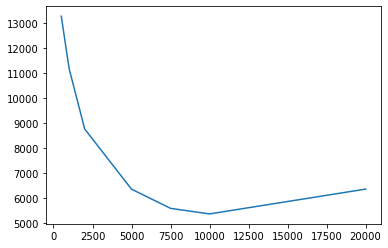

In [20]:
import matplotlib.pyplot as plt
plt.plot(n_train_datas, [val_loss.detach().numpy() for val_loss in best_val_losses])

In [ ]:
plt.plot(n_train_datas, [train_loss.detach().numpy() for train_loss in best_train_losses])

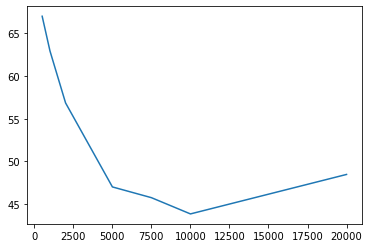

In [23]:

plt.plot(n_train_datas, best_val_abs_losses)

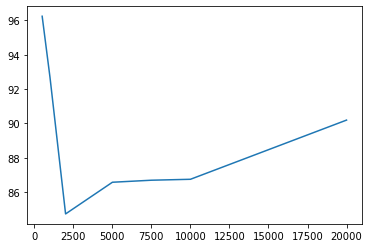

In [32]:
plt.plot(n_train_datas, best_stds)

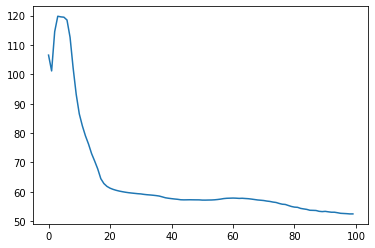

In [ ]:
#inv_transformed = scaler.inverse_transform(np.array(val_abs_losses).reshape(-1, 1))
inv_transformed = val_abs_losses
plt.plot(inv_transformed)


In [ ]:
print(min(inv_transformed), best_std)

52.467445 420.7146


In [ ]:
torch.save(best_model.state_dict(), 'model_weights.pth')
#torch.save(scaler, "model_scaler.pth")

In [ ]:
scaler

MinMaxScaler(feature_range=(0.0001, 1))

In [ ]:
scaler.__dict__.keys()

dict_keys(['feature_range', 'copy', 'clip'])

In [ ]:
scaler.scale_

AttributeError: 'MinMaxScaler' object has no attribute 'scale_'